In [26]:
try:
    import torchinfo
except:
    !pip install torchinfo


In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import torchinfo
from torchinfo import summary


In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
RANDOM_SEED = 123
BATCH_SIZE = 32


torch.manual_seed(RANDOM_SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [30]:
train_normal_transforms = transforms.Compose([
    transforms.ToTensor()
])

train_random_horizontal_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

train_trivial_transforms = transforms.Compose([
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

In [31]:
test_transforms = transforms.Compose([
    transforms.ToTensor()
])

In [32]:
dataset_test = datasets.FER2013(root='/content/drive/MyDrive/Colab Notebooks/24F-INFO-6147/Project/data', split='test', transform=test_transforms)
len(dataset_test)

7178

In [33]:
test_loader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)

In [127]:
class_names = [
    'Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'
]

In [35]:
def show_samples(dataset, indices):
    plt.figure(figsize=(10, 5))
    for i, idx in enumerate(indices[:10]):
        image, label = dataset[idx]
        image = image.squeeze(0) * 255
        image = image.type(torch.uint8)
        plt.subplot(2, 5, i + 1)
        plt.imshow(image.numpy(), cmap='gray')
        plt.title(class_names[label])
        plt.axis('off')
    plt.show()


In [36]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):

    model.train()

    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(DEVICE), y.to(DEVICE)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [37]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):

    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(DEVICE), y.to(DEVICE)

            test_pred_logits = model(X)

            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [38]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    return results

## Custom Model

In [39]:
# Custom Model
class EmotionCNNCustom(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionCNNCustom, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 12 * 12, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [40]:
torch.manual_seed(RANDOM_SEED)
model_custom_test = EmotionCNNCustom().to(DEVICE)
model_custom_test

EmotionCNNCustom(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=7, bias=True)
    (4): Softmax(dim=1)
  )
)

In [41]:
summary(model_custom_test, input_size=[1, 1, 48, 48])

Layer (type:depth-idx)                   Output Shape              Param #
EmotionCNNCustom                         [1, 7]                    --
├─Sequential: 1-1                        [1, 64, 12, 12]           --
│    └─Conv2d: 2-1                       [1, 32, 48, 48]           320
│    └─ReLU: 2-2                         [1, 32, 48, 48]           --
│    └─MaxPool2d: 2-3                    [1, 32, 24, 24]           --
│    └─Conv2d: 2-4                       [1, 64, 24, 24]           18,496
│    └─ReLU: 2-5                         [1, 64, 24, 24]           --
│    └─MaxPool2d: 2-6                    [1, 64, 12, 12]           --
├─Sequential: 1-2                        [1, 7]                    --
│    └─Linear: 2-7                       [1, 128]                  1,179,776
│    └─ReLU: 2-8                         [1, 128]                  --
│    └─Dropout: 2-9                      [1, 128]                  --
│    └─Linear: 2-10                      [1, 7]                    903
│ 

### On Normal Data

In [42]:
dataset_train_normal = datasets.FER2013(root='/content/drive/MyDrive/Colab Notebooks/24F-INFO-6147/Project/data', split='train', transform=train_normal_transforms)
len(dataset_train_normal)

28709

In [43]:
train_normal_loader = DataLoader(dataset_train_normal, batch_size=BATCH_SIZE, shuffle=True)

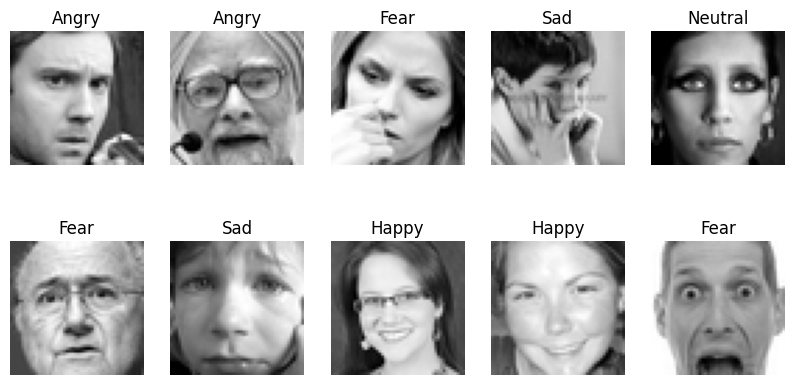

In [44]:
show_samples(dataset_train_normal, range(len(dataset_train_normal)))

In [45]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

NUM_EPOCHS = 50
LEARNING_RATE = 0.001

model_custom_normal = EmotionCNNCustom().to(DEVICE)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_custom_normal.parameters(), lr=LEARNING_RATE)

from timeit import default_timer as timer
start_time = timer()

model_custom_normal_results = train(model=model_custom_normal,
                        train_dataloader=train_normal_loader,
                        test_dataloader=test_loader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.8781 | train_acc: 0.2679 | test_loss: 1.8219 | test_acc: 0.3328
Epoch: 2 | train_loss: 1.8162 | train_acc: 0.3314 | test_loss: 1.7698 | test_acc: 0.3847
Epoch: 3 | train_loss: 1.7924 | train_acc: 0.3597 | test_loss: 1.7511 | test_acc: 0.4044
Epoch: 4 | train_loss: 1.7757 | train_acc: 0.3772 | test_loss: 1.7411 | test_acc: 0.4118
Epoch: 5 | train_loss: 1.7649 | train_acc: 0.3879 | test_loss: 1.7289 | test_acc: 0.4247
Epoch: 6 | train_loss: 1.7515 | train_acc: 0.4027 | test_loss: 1.7259 | test_acc: 0.4299
Epoch: 7 | train_loss: 1.7416 | train_acc: 0.4131 | test_loss: 1.7174 | test_acc: 0.4450
Epoch: 8 | train_loss: 1.7324 | train_acc: 0.4239 | test_loss: 1.7106 | test_acc: 0.4486
Epoch: 9 | train_loss: 1.7241 | train_acc: 0.4309 | test_loss: 1.7105 | test_acc: 0.4439
Epoch: 10 | train_loss: 1.7174 | train_acc: 0.4372 | test_loss: 1.7030 | test_acc: 0.4518
Epoch: 11 | train_loss: 1.7140 | train_acc: 0.4427 | test_loss: 1.6974 | test_acc: 0.4635
Epoch: 12 | train_l

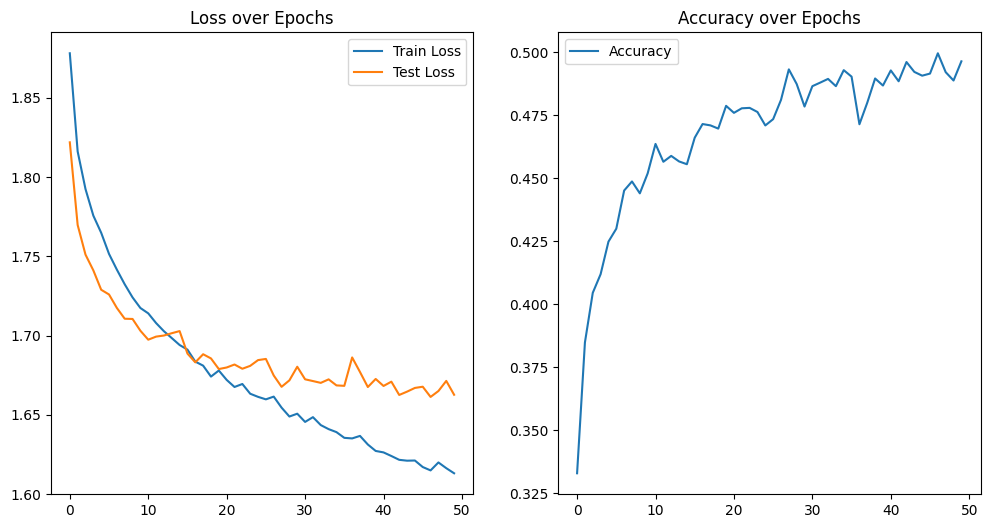

In [46]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(model_custom_normal_results["train_loss"], label='Train Loss')
plt.plot(model_custom_normal_results["test_loss"], label='Test Loss')
plt.legend()
plt.title("Loss over Epochs")
plt.subplot(1, 2, 2)
plt.plot(model_custom_normal_results["test_acc"], label='Accuracy')
plt.legend()
plt.title("Accuracy over Epochs")
plt.show()

In [49]:
torch.save(model_custom_normal.state_dict(), "/content/drive/MyDrive/Colab Notebooks/24F-INFO-6147/Project/data/models/model_custom_normal.pt")

### On Randon Horizontal Flip Dataset

In [50]:
dataset_train_random_horizontal = datasets.FER2013(root='/content/drive/MyDrive/Colab Notebooks/24F-INFO-6147/Project/data', split='train', transform=train_random_horizontal_transforms)
len(dataset_train_random_horizontal)

28709

In [51]:
train_random_horizontal_loader = DataLoader(dataset_train_random_horizontal, batch_size=BATCH_SIZE, shuffle=True)

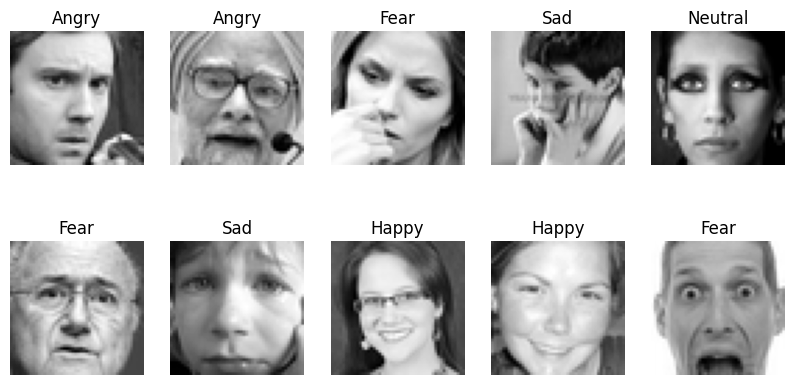

In [52]:
show_samples(dataset_train_random_horizontal, range(len(dataset_train_random_horizontal)))

In [53]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

NUM_EPOCHS = 50
LEARNING_RATE = 0.001

model_custom_random_horizontal = EmotionCNNCustom().to(DEVICE)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_custom_random_horizontal.parameters(), lr=LEARNING_RATE)

from timeit import default_timer as timer
start_time = timer()

model_custom_random_horizontal_results = train(model=model_custom_random_horizontal,
                        train_dataloader=train_random_horizontal_loader,
                        test_dataloader=test_loader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.8823 | train_acc: 0.2654 | test_loss: 1.8090 | test_acc: 0.3464
Epoch: 2 | train_loss: 1.8079 | train_acc: 0.3407 | test_loss: 1.7735 | test_acc: 0.3783
Epoch: 3 | train_loss: 1.7806 | train_acc: 0.3754 | test_loss: 1.7461 | test_acc: 0.4099
Epoch: 4 | train_loss: 1.7667 | train_acc: 0.3894 | test_loss: 1.7389 | test_acc: 0.4168
Epoch: 5 | train_loss: 1.7570 | train_acc: 0.3981 | test_loss: 1.7358 | test_acc: 0.4169
Epoch: 6 | train_loss: 1.7484 | train_acc: 0.4043 | test_loss: 1.7255 | test_acc: 0.4287
Epoch: 7 | train_loss: 1.7429 | train_acc: 0.4099 | test_loss: 1.7243 | test_acc: 0.4292
Epoch: 8 | train_loss: 1.7321 | train_acc: 0.4236 | test_loss: 1.7131 | test_acc: 0.4428
Epoch: 9 | train_loss: 1.7300 | train_acc: 0.4237 | test_loss: 1.7106 | test_acc: 0.4444
Epoch: 10 | train_loss: 1.7223 | train_acc: 0.4348 | test_loss: 1.7106 | test_acc: 0.4434
Epoch: 11 | train_loss: 1.7218 | train_acc: 0.4330 | test_loss: 1.7091 | test_acc: 0.4451
Epoch: 12 | train_l

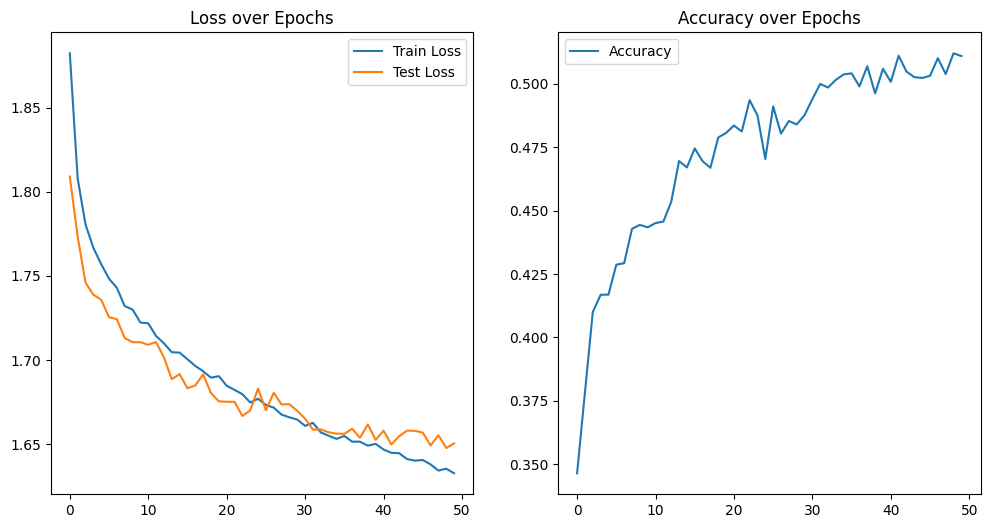

In [54]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(model_custom_random_horizontal_results["train_loss"], label='Train Loss')
plt.plot(model_custom_random_horizontal_results["test_loss"], label='Test Loss')
plt.legend()
plt.title("Loss over Epochs")
plt.subplot(1, 2, 2)
plt.plot(model_custom_random_horizontal_results["test_acc"], label='Accuracy')
plt.legend()
plt.title("Accuracy over Epochs")
plt.show()

In [55]:
torch.save(model_custom_random_horizontal.state_dict(), "/content/drive/MyDrive/Colab Notebooks/24F-INFO-6147/Project/data/models/model_custom_random_horizontal.pt")

### On Trivial Augmented Dataset

In [56]:
dataset_train_trivial = datasets.FER2013(root='/content/drive/MyDrive/Colab Notebooks/24F-INFO-6147/Project/data', split='train', transform=train_trivial_transforms)
len(dataset_train_trivial)

28709

In [57]:
train_trivial_loader = DataLoader(dataset_train_trivial, batch_size=BATCH_SIZE, shuffle=True)

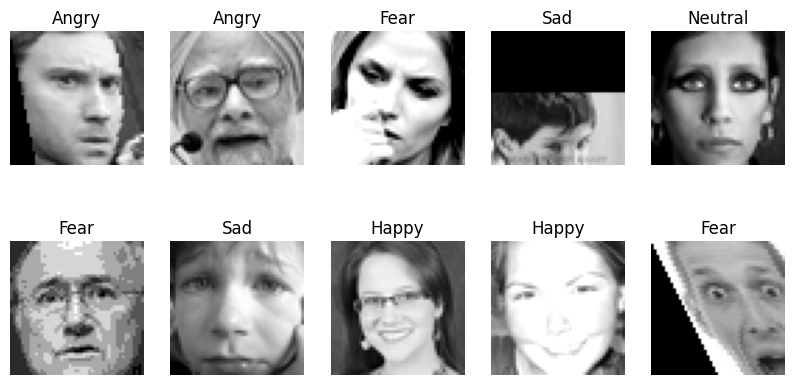

In [58]:
show_samples(dataset_train_trivial, range(len(dataset_train_trivial)))

In [59]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

NUM_EPOCHS = 50
LEARNING_RATE = 0.001

model_custom_trivial = EmotionCNNCustom().to(DEVICE)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_custom_trivial.parameters(), lr=LEARNING_RATE)

from timeit import default_timer as timer
start_time = timer()

model_custom_trivial_results = train(model=model_custom_trivial,
                        train_dataloader=train_trivial_loader,
                        test_dataloader=test_loader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.8915 | train_acc: 0.2511 | test_loss: 1.8508 | test_acc: 0.2934
Epoch: 2 | train_loss: 1.8585 | train_acc: 0.2822 | test_loss: 1.7952 | test_acc: 0.3581
Epoch: 3 | train_loss: 1.8395 | train_acc: 0.3069 | test_loss: 1.7718 | test_acc: 0.3838
Epoch: 4 | train_loss: 1.8272 | train_acc: 0.3177 | test_loss: 1.7592 | test_acc: 0.3911
Epoch: 5 | train_loss: 1.8211 | train_acc: 0.3270 | test_loss: 1.7530 | test_acc: 0.3990
Epoch: 6 | train_loss: 1.8178 | train_acc: 0.3276 | test_loss: 1.7461 | test_acc: 0.4098
Epoch: 7 | train_loss: 1.8117 | train_acc: 0.3367 | test_loss: 1.7400 | test_acc: 0.4144
Epoch: 8 | train_loss: 1.8069 | train_acc: 0.3393 | test_loss: 1.7437 | test_acc: 0.4105
Epoch: 9 | train_loss: 1.8031 | train_acc: 0.3444 | test_loss: 1.7380 | test_acc: 0.4186
Epoch: 10 | train_loss: 1.8005 | train_acc: 0.3474 | test_loss: 1.7415 | test_acc: 0.4113
Epoch: 11 | train_loss: 1.7968 | train_acc: 0.3530 | test_loss: 1.7246 | test_acc: 0.4306
Epoch: 12 | train_l

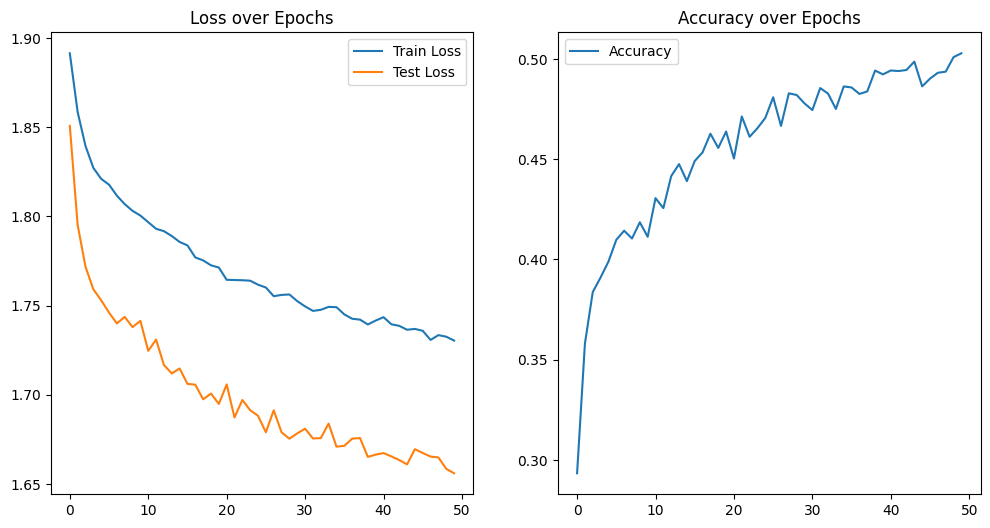

In [60]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(model_custom_trivial_results["train_loss"], label='Train Loss')
plt.plot(model_custom_trivial_results["test_loss"], label='Test Loss')
plt.legend()
plt.title("Loss over Epochs")
plt.subplot(1, 2, 2)
plt.plot(model_custom_trivial_results["test_acc"], label='Accuracy')
plt.legend()
plt.title("Accuracy over Epochs")
plt.show()

In [61]:
torch.save(model_custom_trivial.state_dict(), "/content/drive/MyDrive/Colab Notebooks/24F-INFO-6147/Project/data/models/model_custom_trivial.pt")

### On Trivial Augmented Dataset - LR=0.01

In [62]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

NUM_EPOCHS = 50
LEARNING_RATE = 0.001

model_custom_trivial_lr = EmotionCNNCustom().to(DEVICE)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_custom_trivial_lr.parameters(), lr=LEARNING_RATE)

from timeit import default_timer as timer
start_time = timer()

model_custom_trivial_lr_results = train(model=model_custom_trivial_lr,
                        train_dataloader=train_trivial_loader,
                        test_dataloader=test_loader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.8934 | train_acc: 0.2492 | test_loss: 1.8574 | test_acc: 0.2724
Epoch: 2 | train_loss: 1.8614 | train_acc: 0.2783 | test_loss: 1.8026 | test_acc: 0.3512
Epoch: 3 | train_loss: 1.8456 | train_acc: 0.2952 | test_loss: 1.7765 | test_acc: 0.3783
Epoch: 4 | train_loss: 1.8334 | train_acc: 0.3131 | test_loss: 1.7639 | test_acc: 0.3884
Epoch: 5 | train_loss: 1.8271 | train_acc: 0.3205 | test_loss: 1.7599 | test_acc: 0.3903
Epoch: 6 | train_loss: 1.8227 | train_acc: 0.3223 | test_loss: 1.7735 | test_acc: 0.3732
Epoch: 7 | train_loss: 1.8170 | train_acc: 0.3276 | test_loss: 1.7542 | test_acc: 0.3991
Epoch: 8 | train_loss: 1.8137 | train_acc: 0.3334 | test_loss: 1.7480 | test_acc: 0.4037
Epoch: 9 | train_loss: 1.8113 | train_acc: 0.3368 | test_loss: 1.7483 | test_acc: 0.4057
Epoch: 10 | train_loss: 1.8085 | train_acc: 0.3386 | test_loss: 1.7485 | test_acc: 0.4102
Epoch: 11 | train_loss: 1.8035 | train_acc: 0.3430 | test_loss: 1.7385 | test_acc: 0.4169
Epoch: 12 | train_l

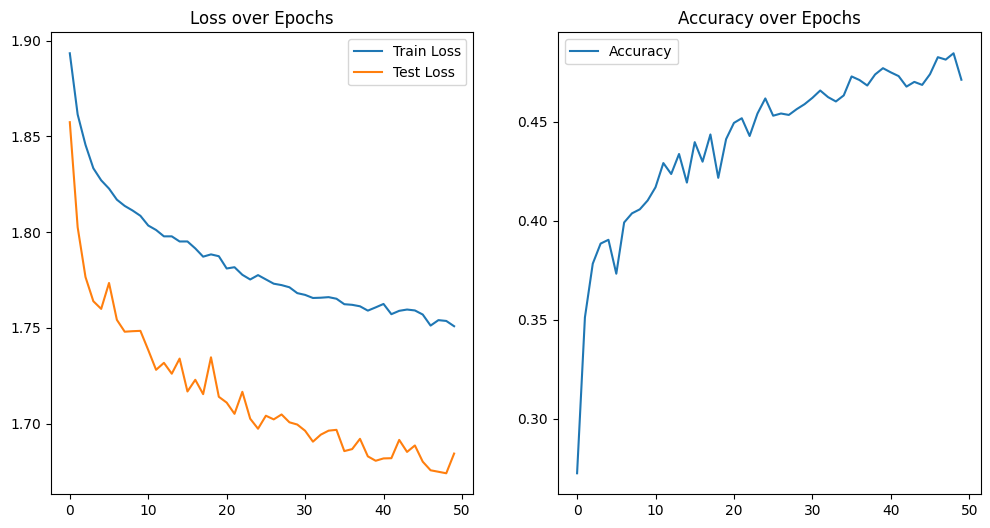

In [63]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(model_custom_trivial_lr_results["train_loss"], label='Train Loss')
plt.plot(model_custom_trivial_lr_results["test_loss"], label='Test Loss')
plt.legend()
plt.title("Loss over Epochs")
plt.subplot(1, 2, 2)
plt.plot(model_custom_trivial_lr_results["test_acc"], label='Accuracy')
plt.legend()
plt.title("Accuracy over Epochs")
plt.show()

In [64]:
torch.save(model_custom_trivial_lr.state_dict(), "/content/drive/MyDrive/Colab Notebooks/24F-INFO-6147/Project/data/models/model_custom_trivial_lr.pt")

## VGG19 Replicated Model

In [65]:
# Full VGG 19
class EmotionVGGCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionVGGCNN, self).__init__()

        self.features = nn.Sequential(
            *self._feature_block(1,64),
            *self._feature_block(64,64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            *self._feature_block(64,128),
            *self._feature_block(128,128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            *self._feature_block(128,256),
            *self._feature_block(256,256),
            *self._feature_block(256,256),
            *self._feature_block(256,256),
            nn.MaxPool2d(kernel_size=2, stride=2),
            *self._feature_block(256,512),
            *self._feature_block(512,512),
            *self._feature_block(512,512),
            *self._feature_block(512,512),
            nn.MaxPool2d(kernel_size=2, stride=2),
            *self._feature_block(512,512),
            *self._feature_block(512,512),
            *self._feature_block(512,512),
            *self._feature_block(512,512),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512*1*1, num_classes),
            nn.Softmax(dim=1)
        )

    def _feature_block(self,in_channels, out_channels):
      return [
          nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1),
          nn.BatchNorm2d(out_channels),
          nn.ReLU(inplace=True),
      ]

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [66]:
torch.manual_seed(RANDOM_SEED)
model_vgg_test = EmotionVGGCNN().to(DEVICE)
model_vgg_test

EmotionVGGCNN(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2

In [67]:
summary(model_vgg_test, input_size=[1, 1, 48, 48])

Layer (type:depth-idx)                   Output Shape              Param #
EmotionVGGCNN                            [1, 7]                    --
├─Sequential: 1-1                        [1, 512, 1, 1]            --
│    └─Conv2d: 2-1                       [1, 64, 48, 48]           640
│    └─BatchNorm2d: 2-2                  [1, 64, 48, 48]           128
│    └─ReLU: 2-3                         [1, 64, 48, 48]           --
│    └─Conv2d: 2-4                       [1, 64, 48, 48]           36,928
│    └─BatchNorm2d: 2-5                  [1, 64, 48, 48]           128
│    └─ReLU: 2-6                         [1, 64, 48, 48]           --
│    └─MaxPool2d: 2-7                    [1, 64, 24, 24]           --
│    └─Conv2d: 2-8                       [1, 128, 24, 24]          73,856
│    └─BatchNorm2d: 2-9                  [1, 128, 24, 24]          256
│    └─ReLU: 2-10                        [1, 128, 24, 24]          --
│    └─Conv2d: 2-11                      [1, 128, 24, 24]          147,58

In [68]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

NUM_EPOCHS = 50
LEARNING_RATE = 0.001

model_vgg_trivial = EmotionVGGCNN().to(DEVICE)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_vgg_trivial.parameters(), lr=LEARNING_RATE)

from timeit import default_timer as timer
start_time = timer()

model_vgg_trivial_results = train(model=model_vgg_trivial,
                        train_dataloader=train_trivial_loader,
                        test_dataloader=test_loader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.9004 | train_acc: 0.2462 | test_loss: 1.8969 | test_acc: 0.2473
Epoch: 2 | train_loss: 1.8974 | train_acc: 0.2495 | test_loss: 1.8946 | test_acc: 0.2476
Epoch: 3 | train_loss: 1.8940 | train_acc: 0.2510 | test_loss: 1.8997 | test_acc: 0.2473
Epoch: 4 | train_loss: 1.8935 | train_acc: 0.2510 | test_loss: 1.8961 | test_acc: 0.2473
Epoch: 5 | train_loss: 1.8936 | train_acc: 0.2506 | test_loss: 1.8941 | test_acc: 0.2473
Epoch: 6 | train_loss: 1.8937 | train_acc: 0.2512 | test_loss: 1.8970 | test_acc: 0.2473
Epoch: 7 | train_loss: 1.8910 | train_acc: 0.2516 | test_loss: 1.8977 | test_acc: 0.2473
Epoch: 8 | train_loss: 1.8870 | train_acc: 0.2515 | test_loss: 1.8746 | test_acc: 0.2473
Epoch: 9 | train_loss: 1.8673 | train_acc: 0.2629 | test_loss: 1.8157 | test_acc: 0.3192
Epoch: 10 | train_loss: 1.8356 | train_acc: 0.2949 | test_loss: 1.7984 | test_acc: 0.3253
Epoch: 11 | train_loss: 1.8165 | train_acc: 0.3192 | test_loss: 1.7891 | test_acc: 0.3553
Epoch: 12 | train_l

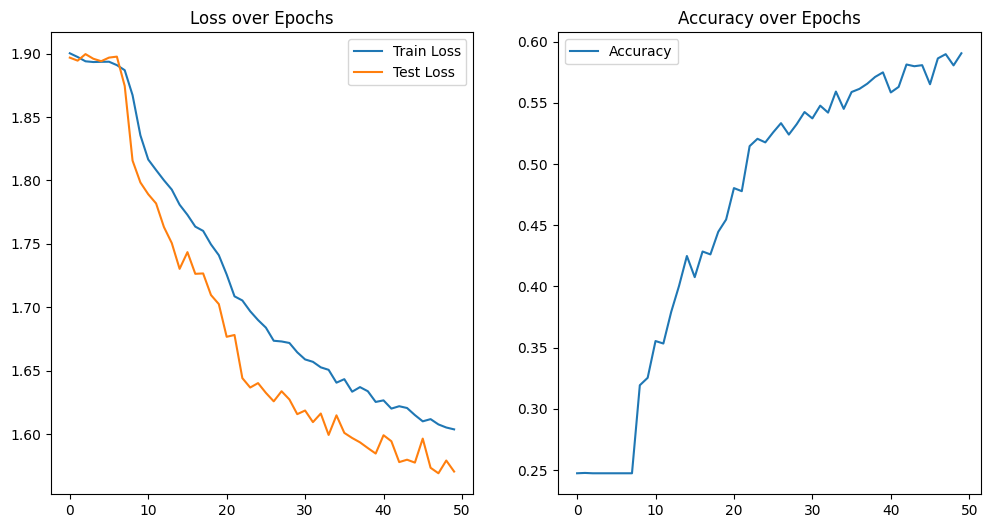

In [69]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(model_vgg_trivial_results["train_loss"], label='Train Loss')
plt.plot(model_vgg_trivial_results["test_loss"], label='Test Loss')
plt.legend()
plt.title("Loss over Epochs")
plt.subplot(1, 2, 2)
plt.plot(model_vgg_trivial_results["test_acc"], label='Accuracy')
plt.legend()
plt.title("Accuracy over Epochs")
plt.show()

In [70]:
torch.save(model_vgg_trivial.state_dict(), "/content/drive/MyDrive/Colab Notebooks/24F-INFO-6147/Project/data/models/model_vgg_trivial.pt")

## Result Comparison

In [83]:
import pandas as pd
normal_result={
    "model_name": "Custom Model",
    "train_loss" : model_custom_normal_results["train_loss"][-1],
    "train_acc": model_custom_normal_results["train_acc"][-1],
    "test_loss": model_custom_normal_results["test_loss"][-1],
    "test_acc": model_custom_normal_results["test_acc"][-1]
}
random_horizontal_result={
    "model_name": "Custom Model with Randon Horizontal Flip",
    "train_loss" : model_custom_random_horizontal_results["train_loss"][-1],
    "train_acc": model_custom_random_horizontal_results["train_acc"][-1],
    "test_loss": model_custom_random_horizontal_results["test_loss"][-1],
    "test_acc": model_custom_random_horizontal_results["test_acc"][-1]
}
trivial_result={
    "model_name": "Custom Model with Trivial Augmentation",
    "train_loss" : model_custom_trivial_results["train_loss"][-1],
    "train_acc": model_custom_trivial_results["train_acc"][-1],
    "test_loss": model_custom_trivial_results["test_loss"][-1],
    "test_acc": model_custom_trivial_results["test_acc"][-1]
}
trivial_lr_result={
    "model_name": "Custom Model with Trivial Augmentation - LR=0.01",
    "train_loss" : model_custom_trivial_lr_results["train_loss"][-1],
    "train_acc": model_custom_trivial_lr_results["train_acc"][-1],
    "test_loss": model_custom_trivial_lr_results["test_loss"][-1],
    "test_acc": model_custom_trivial_lr_results["test_acc"][-1]
}
vgg_result = {
    "model_name": "VGG19 Replicated Model",
    "train_loss" : model_vgg_trivial_results["train_loss"][-1],
    "train_acc": model_vgg_trivial_results["train_acc"][-1],
    "test_loss": model_vgg_trivial_results["test_loss"][-1],
    "test_acc": model_vgg_trivial_results["test_acc"][-1]
}
results_df = pd.DataFrame([normal_result, random_horizontal_result, trivial_result,trivial_lr_result, vgg_result])
results_df

,model_name,train_loss,train_acc,test_loss,test_acc
0,Custom Model,1.613096,0.547418,1.662641,0.496306
1,Custom Model with Randon Horizontal Flip,1.632716,0.528174,1.650464,0.510889
2,Custom Model with Trivial Augmentation,1.730406,0.422481,1.656018,0.502833
3,Custom Model with Trivial Augmentation - LR=0.01,1.750880,0.401629,1.684389,0.471167
4,VGG19 Replicated Model,1.603622,0.556076,1.570347,0.590417


# Real Image Testing

In [86]:
from PIL import Image

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.0,), (1.0,)),
])

image_path = "/content/drive/MyDrive/Colab Notebooks/24F-INFO-6147/Project/data/real/angry1.jpg"
image = Image.open(image_path)

image_tensor = transform(image).to(DEVICE)

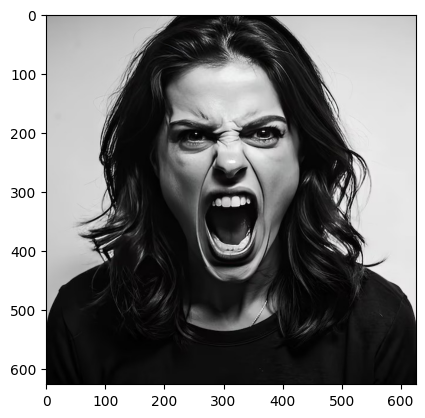

In [87]:
imgplot = plt.imshow(image)
plt.show()

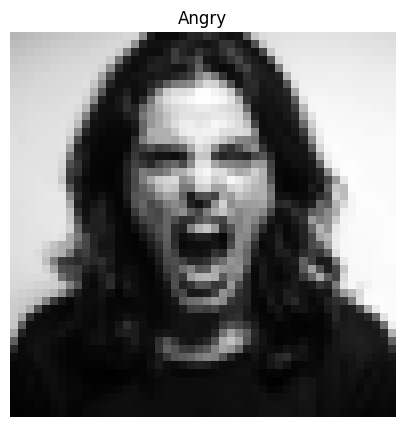

In [88]:
plt.figure(figsize=(10, 5))
image = image_tensor.cpu().squeeze(0) * 255
image = image.type(torch.uint8)
plt.imshow(image.numpy(), cmap='gray')
plt.title('Angry')
plt.axis('off')
plt.show()

In [129]:
custom_normal_out = model_custom_normal(image_tensor.unsqueeze(0))
_, custom_normal_predicted = torch.max(custom_normal_out, 1)
print(custom_normal_predicted)
print(class_names[custom_normal_predicted])

tensor([6], device='cuda:0')
Neutral


In [130]:
custom_random_horizontal_out = model_custom_random_horizontal(image_tensor.unsqueeze(0))
_, custom_random_horizontal_predicted = torch.max(custom_random_horizontal_out, 1)
print(custom_random_horizontal_predicted)
print(class_names[custom_random_horizontal_predicted])

tensor([3], device='cuda:0')
Happy


In [131]:
custom_trivial_out = model_custom_trivial(image_tensor.unsqueeze(0))
_, custom_trivial_predicted = torch.max(custom_trivial_out, 1)
print(custom_trivial_predicted)
print(class_names[custom_trivial_predicted])

tensor([0], device='cuda:0')
Angry


In [132]:
custom_trivial_lr_out = model_custom_trivial_lr(image_tensor.unsqueeze(0))
_, custom_trivial_lr_predicted = torch.max(custom_trivial_lr_out, 1)
print(custom_trivial_lr_predicted)
print(class_names[custom_trivial_lr_predicted])

tensor([4], device='cuda:0')
Sad


In [133]:
vgg_trivial_out = model_vgg_trivial(image_tensor.unsqueeze(0))
_, vgg_trivial_predicted = torch.max(vgg_trivial_out, 1)
print(vgg_trivial_predicted)
print(class_names[vgg_trivial_predicted])

tensor([0], device='cuda:0')
Angry


In [136]:
real_img_result={
    "true_label": "Angry",
    "normal_pred" : class_names[custom_normal_predicted],
    "rand_hori_pred": class_names[custom_random_horizontal_predicted],
    "tri_pred": class_names[custom_trivial_predicted],
    "tri_lr_pred": class_names[custom_trivial_lr_predicted],
    "vgg_tri_pred": class_names[vgg_trivial_predicted]
}
real_image_df = pd.DataFrame([real_img_result])
real_image_df

,true_label,normal_pred,rand_hori_pred,tri_pred,tri_lr_pred,vgg_tri_pred
0,Angry,Neutral,Happy,Angry,Sad,Angry


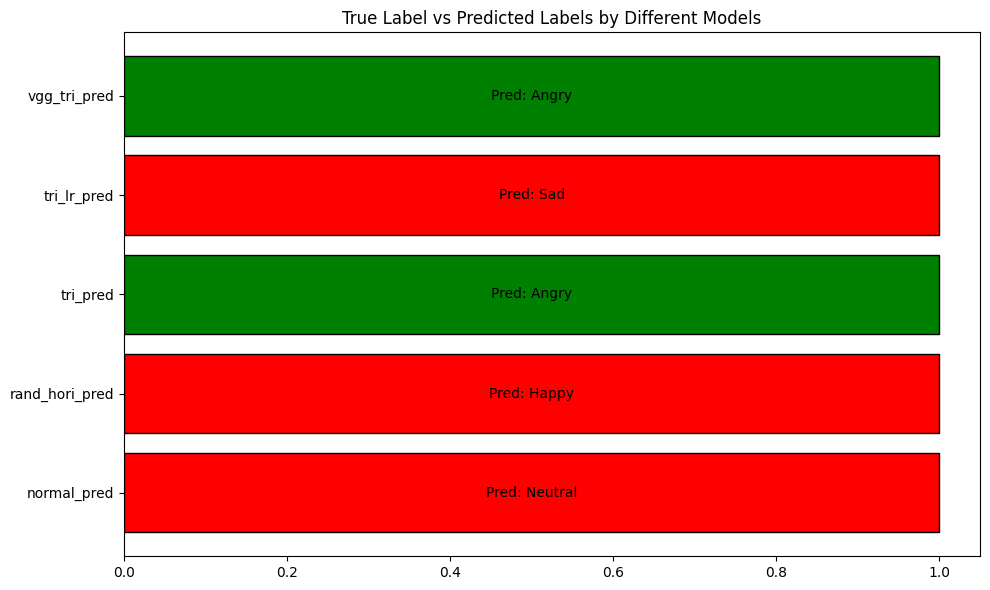

In [139]:
import matplotlib.pyplot as plt

methods = list(real_img_result.keys())[1:]
predictions = [real_img_result[method] for method in methods]
true_label = real_img_result["true_label"]

colors = ["green" if pred == true_label else "red" for pred in predictions]

plt.figure(figsize=(10, 6))
plt.barh(methods, [1] * len(predictions), color=colors, edgecolor='black')
plt.title("True Label vs Predicted Labels by Different Models")
plt.yticks(range(len(methods)), labels=methods)

for i, (method, pred, color) in enumerate(zip(methods, predictions, colors)):
    plt.text(0.5, i, f"Pred: {pred}", va='center', ha='center', color="white" if color == "blue" else "black")

plt.tight_layout()
plt.show()
